In [2]:
from visualizer import calibration
import visual

from PyQt5 import QtCore
import tifffile
from skimage.io import imread
from skimage.io.collection import alphanumeric_key
from dask import delayed
from glob import glob
import dask.array as da
import matplotlib.pyplot as plt
import numpy as np
import napari
from napari import Viewer
import os
import zarr
from skimage.registration import phase_cross_correlation
import cv2 as cv
from skimage import io
from skimage.morphology import skeletonize
from skan import Skeleton
import scipy.ndimage as ndi
import cupy as cp 
import waveorder as wo
from waveorder.io.multipagetiff import  MicromanagerOmeTiffReader
from aicsimageio import AICSImage,imread, imread_dask

import cv2 as cv
%gui qt 
%matplotlib inline
plt.style.use('dark_background')


In [3]:
viewer = napari.Viewer()

In [4]:
### Enter the filepath for the data directory
main_dir =r'F:\DATA\20220507_M25_ZW495_9'   #5 fast dynamics of big worm
###Enter the filepath for background images
bg_dir = r'F:\Test_ignore\20220513_M25_bg_16bit'
### Enter the filepath for Calibration Dataset (PSF) or offset file
psf_dir = r'F:\Test_ignore\220508_190nmSteps_postitive2negative_1'
# psf_dir = r'F:\Test_ignore\220508_380nmSteps_minusplus_reversed_1'
#Get Folders and files
main_dirs = sorted(glob(main_dir + '/CAM*/'), key=alphanumeric_key)
bg_folders = sorted(glob(bg_dir + '/CAM*/'), key=alphanumeric_key)

# Load offsets from desired folder 
processed_files = main_dir + '/'+'processed_files'
if not os.path.exists(processed_files):
    os.makedirs(processed_files)

offset_dir = os.path.join(psf_dir + '/'+'processed_files')
offsets_file = os.path.join(offset_dir,"offsets.csv")
offsets_file_pcc = os.path.join(offset_dir,"offsets_pcc.csv")

if os.path.exists(offsets_file):
    with open(offsets_file) as file_name:
        print("loading offsets")
        offsets = np.loadtxt(file_name, delimiter=",")

if os.path.exists(offsets_file_pcc):
    with open(offsets_file) as file_name:
        print("loading offsets")
        offsets_pcc = np.loadtxt(file_name, delimiter=",")
## Quick Visualizer of the selected planes
# center_planes = calibration.lazy_dask_stack(main_dir,num_cams=5,px_depth='uint16', height=608, width =608)
# napari.add_image(center_planes, name='center_planes',scale=[z_scale,1,1],multiscale=False)

loading offsets
loading offsets


In [5]:
# Scope Parameters
cam_px = 6.0e-6
totalmag = 15.75
zstep = 2e-6

px_size_img = cam_px/totalmag
z_scale = zstep/px_size_img

In [18]:
folder = main_dirs[12]
file_extension = folder + '/' + '*.raw'
file_names = sorted(glob(file_extension),key=alphanumeric_key)
raw_ds = calibration.dask_raw_ds(folder,px_depth='uint16', width=608,height=608)
dask_raw_ds = da.stack(raw_ds,axis=1)


<Image layer 'dask_raw_ds' at 0x12315d8cfa0>

In [19]:
dask_raw_ds.shape

(1, 600, 608, 608)

In [315]:
crop_stack = dask_raw_ds[:,60:260,:,:]
viewer.add_image(crop_stack)
crop_stack_gauss = ndi.gaussian_filter(crop_stack,sigma=5)
viewer.add_image(crop_stack_gauss)

<Image layer 'crop_stack_gauss [1]' at 0x12389a9dee0>

<Image layer 'binary_stack [1]' at 0x123860adc40>

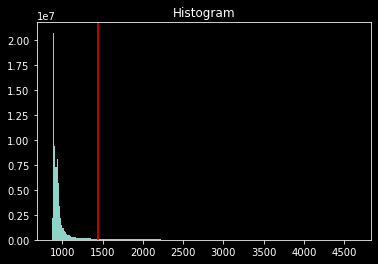

In [25]:
from skimage.filters import threshold_otsu, threshold_yen

thresh_otsu = threshold_otsu(crop_stack_gauss)
binary_stack = crop_stack_gauss > thresh_otsu

plt.hist(crop_stack_gauss.ravel(), bins=256)
plt.title('Histogram')
plt.axvline(thresh_otsu, color='r')
viewer.add_image(binary_stack)

In [26]:
binary_stack_filled = ndi.binary_fill_holes(binary_stack)
wo.image_stack_viewer(binary_stack_filled)

interactive(children=(IntSlider(value=0, description='stack_idx_1', max=0), IntSlider(value=0, description='st…

<function waveorder.visual.image_stack_viewer.<locals>.interact_plot_4D(stack_idx_1, stack_idx_2)>

In [32]:
binary_stack_filled.shape
binary_stack_filled3d = np.squeeze(binary_stack_filled)

In [136]:
# perform skeletonization
skeleton =np.array([skeletonize(binary_stack_filled3d[i]) for i in range(binary_stack_filled3d.shape[0])])
print(skeleton.shape)
viewer.add_image(skeleton, colormap='magenta', blending='additive')

(200, 608, 608)


<Image layer 'skeleton [1]' at 0x12389a2f640>

In [163]:
from skan import Skeleton

sk_skeleton =[Skeleton(skeleton[i]) for i in range(skeleton.shape[0])]

In [184]:
print(len(sk_skeleton[10].coordinates))
print(sk_skeleton[10].path_lengths())
print(sk_skeleton[10].distances)

381
[429.11984105]
[429.11984105]


In [188]:
a = [ sk_skeleton[i].coordinates[sk_skeleton[i].degrees == 1] for i in range(len(sk_skeleton))]


In [352]:
# Finding the points where we have start/ends
end_points =[]
for k in range(len(sk_skeleton)):
    for i, val in enumerate(sk_skeleton[k].coordinates[sk_skeleton[k].degrees == 1]):
      end_points.append([k,val[0],val[1]])

np_endPoint = np.array(end_points)
print(np_endPoint.shape)


(462, 3)


In [353]:
np_endPoint

array([[  0.,  66., 211.],
       [  0., 270., 390.],
       [  1.,  72., 209.],
       ...,
       [199., 440., 189.],
       [199., 474., 212.],
       [199., 540., 322.]])

In [276]:
viewer.add_points(np_endPoint, face_color='cornflowerblue')

<Points layer 'np_endPoint [1]' at 0x12432f7df10>

In [295]:
length = sk_skeleton[i].path_lengths()
length.shape
length[0]
length[0]

395.24978336205663

In [366]:
from skan import summarize
#Attempting to plot multiple points in skeleton
i=0
branch = summarize(sk_skeleton[i])
branch.head()

,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-dst-0,image-coord-dst-1,coord-src-0,coord-src-1,coord-dst-0,coord-dst-1,euclidean-distance
0,1,1,222,395.249783,0,1.0,0.0,66.0,211.0,270.0,390.0,66.0,211.0,270.0,390.0,271.398231


In [ ]:
from scipy.ndimage import distance_transform_edt
sk_skeleton[0].coo
distance_transform_edt()

In [393]:

coords = sk_skeleton[i].coordinates
length = sk_skeleton[i].path_lengths()

print(coords[::10])
print(int(length/5))
print(type(length.astype(int)))
select_coords = sk_skeleton[i].coordinates  #ignore the first and last points
# print(select_coords.shape)
# print(select_coords[1,:])
# x = []
# select_coords = select_coords[np.newaxis,:,:]
# select_coords[i,:,:] = select_coords[1,:]
# x = np.array(x)
# print(x.shape)
# for k in range(len(sk_skeleton)):
#     x = sk_skeleton[k].coordinates[1:-2:70]
#     print(x)


[[  0.   0.]
 [ 75. 208.]
 [ 85. 206.]
 [ 95. 205.]
 [105. 204.]
 [115. 202.]
 [125. 200.]
 [135. 198.]
 [145. 197.]
 [155. 195.]
 [165. 194.]
 [175. 194.]
 [185. 195.]
 [195. 197.]
 [205. 199.]
 [215. 203.]
 [225. 207.]
 [235. 212.]
 [245. 218.]
 [255. 226.]
 [264. 236.]
 [270. 378.]
 [270. 388.]
 [271. 377.]
 [274. 251.]
 [276. 256.]
 [277. 357.]
 [279. 351.]
 [280. 348.]
 [282. 276.]
 [283. 282.]
 [284. 330.]
 [285. 326.]
 [287. 294.]
 [288. 299.]
 [288. 311.]]
79
<class 'numpy.ndarray'>
[395.24978336]
0
[395.24978336]
[395.24978336]
[395.24978336]
[395.24978336]
[395.24978336]
[395.24978336]
[395.24978336]
[395.24978336]
[395.24978336]
[395.24978336]
[395.24978336]
[395.24978336]
[395.24978336]
[395.24978336]
[395.24978336]
[395.24978336]
[395.24978336]
[395.24978336]
[395.24978336]
[395.24978336]
[395.24978336]
[395.24978336]
[395.24978336]
[395.24978336]
[395.24978336]
[395.24978336]
[395.24978336]
[395.24978336]
[395.24978336]
[395.24978336]
[395.24978336]
[395.24978336]
[395.24

In [395]:
select_coords =[]
path_length = []
id =[]
for k in range(len(sk_skeleton)):
    length = sk_skeleton[k].path_lengths()
    # path_length.append(length)
    for index,item in enumerate(sk_skeleton[k].coordinates):
        if index%(int(length[0]/5)) ==0:
            # id.append(index)
            select_coords.append([k,item[0],item[1]])
# select_coords = np.array(select_coords)
print(id)
print(path_length)

[]
[]


In [439]:
coords_np = np.array(select_coords)
coords_np.shape
coords_np[2,1:]

array([223., 206.])

In [450]:
coord_a =coords_np[1,1:]
coord_b =coords_np[2,1:]

In [458]:
"""
Refresh on vector calc
https://stackoverflow.com/questions/7469959/given-2-points-how-do-i-draw-a-line-at-a-right-angle-to-the-line-formed-by-the-t/7470098#7470098
The matrix representation of 2D transformation:
x' = xcos(t) - ysin(t)
y' = xsin(t)  - ycost(t)

so if t =90 deg then 
x'=-y
y'= x

then normals to line segment would be:
(-dy,dx)(dy,-dx)

"""
width = 100
skel_perp = np.empty((2,), dtype=np.float32)

perp_line = [-(coord_b[1]-coord_a[1]), coord_b[0]-coord_a[0]]
# Take the magnitude to get the length of the vector 
norm = np.sqrt(perp_line[0]*perp_line[0]+perp_line[1]*perp_line[1])

skel_perp[0] = (perp_line[0] / norm) * (width / 2)
skel_perp[1] = (perp_line[1] / norm) * (width / 2)

##Box origin is 'lower' instead of upper
bot_l = coord_a + skel_perp
top_l = coord_b + skel_perp
top_r = coord_b - skel_perp # 
bot_r = coord_a - skel_perp # 

bbox_rect = np.array(
    [bot_l, top_l, top_r, bot_r]
)


In [470]:
#Plotting left and right boxes
width = 50
skel_perp = np.empty((2,), dtype=np.float32)

perp_line = [-(coord_b[1]-coord_a[1]), coord_b[0]-coord_a[0]]
# Take the magnitude to get the length of the vector 
norm = np.sqrt(perp_line[0]*perp_line[0]+perp_line[1]*perp_line[1])

#Normal to skeleton
skel_perp[0] = (perp_line[0] / norm) * (width / 2)
skel_perp[1] = (perp_line[1] / norm) * (width / 2)
# skel_perp[1] = (perp_line[1] / norm) 

##Box origin is 'lower' instead of upper
bot_l = coord_a + skel_perp
top_l = coord_b + skel_perp
top_r = coord_b - skel_perp # 
bot_r = coord_a - skel_perp # 

bbox_rect_left = np.array(
    [coord_a, coord_b, top_l, bot_l]
)

bbox_rect_right = np.array(
    [coord_a, coord_b, top_r, bot_r]
)

In [471]:
viewer.add_shapes(
    bbox_rect_left,
    name='bounding box',
    face_color ='blue'
)
viewer.add_shapes(
    bbox_rect_right,
    name='bounding box',
    face_color='red'
)

<Shapes layer 'bounding box [3]' at 0x12392eff8b0>

In [402]:
binary_stack_filled_1=np.squeeze(binary_stack_filled)
print(binary_stack_filled_1.shape)

(200, 608, 608)


In [416]:
from skimage.measure import label, regionprops_table

properties = regionprops_table(
    binary_stack_filled_1[0].astype(np.uint8), properties=('label', 'bbox', 'perimeter', 'area')
)

#Addinc circularity to the table
properties['circularity'] = circularity(
    properties['perimeter'], properties['area']
)

bbox_rects = make_bbox([properties[f'bbox-{i}'] for i in range(4)])

# specify the display parameters for the text
text_parameters = {
    'string': 'label: {label}\ncirc: {circularity:.2f}',
    'size': 12,
    'color': 'green',
    'anchor': 'upper_left',
    'translation': [-3, 0],
}

shapes_layer = viewer.add_shapes(
    bbox_rects,
    face_color='transparent',
    edge_color='green',
    properties=properties,
    text=text_parameters,
    name='bounding box',
)

In [414]:
def make_bbox(coord_a,coord_b,width):
    """Get the coordinates of the corners of a
    bounding box from the extents

    Parameters
    ----------
    bbox_extents : list (4xN)
        List of the extents of the bounding boxes for each of the N regions.
        Should be ordered: [min_row, min_column, max_row, max_column]

    Returns
    -------
    bbox_rect : np.ndarray
        The corners of the bounding box. Can be input directly into a
        napari Shapes layer.
    """
    # preallocates some internal data structures
    skel_perp = np.empty((2,), dtype=np.float32)

    perp_line = [-(coord_b[1]-coord_a[1]), coord_b[0]-coord_a[0]]
    norm = np.sqrt(perp_line[0]*perp_line[0]+perp_line[1]*perp_line[1])

    skel_perp[0] = (perp_line[0] / norm) * (width / 2)
    skel_perp[1] = (perp_line[1] / norm) * (width / 2)

    minr = coord_a + skel_perp
    minc = coord_b + skel_perp
    maxr = coord_b - skel_perp
    maxc = coord_a - skel_perp

    bbox_rect = np.array(
        [[minr, minc], [maxr, minc], [maxr, maxc], [minr, maxc]]
    )
    bbox_rect = np.moveaxis(bbox_rect, 2, 0)

    return bbox_rect

In [328]:
s_coord = np.array(s_coord)
print(s_coord)
s_coord.shape

[array([[ 66., 211.],
        [116., 202.],
        [166., 194.],
        [216., 203.],
        [265., 237.],
        [276., 257.],
        [283., 283.],
        [288., 312.]]) array([[ 72., 209.],
                              [122., 200.],
                              [172., 193.],
                              [222., 205.],
                              [269., 243.],
                              [277., 259.],
                              [283., 333.]]) array([[ 72., 209.],
                                                    [122., 200.],
                                                    [172., 193.],
                                                    [222., 205.],
                                                    [268., 386.],
                                                    [277., 257.],
                                                    [282., 331.]])
 array([[ 69., 209.],
        [119., 200.],
        [169., 193.],
        [219., 202.],
        [267., 238.],
        [

C:\Users\yoshi\AppData\Local\Temp\ipykernel_25200\4197690745.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  s_coord = np.array(s_coord)


(200,)

In [390]:
select_coords.shape

array([[  0.,   0.,   0.],
       [  0., 144., 197.],
       [  0., 223., 206.],
       ...,
       [199., 420., 184.],
       [199., 501., 228.],
       [199., 523., 276.]])

In [391]:
viewer.add_points(select_coords, face_color='cornflowerblue')

<Points layer 'select_coords' at 0x12431f1b910>

In [386]:
import pims
import trackpy as tp

In [ ]:
features = tp.locate(np_stack[12], diameter=(7,7,7), threshold =84,minmass=11000, separation= (3,1,1))
print('Features found: {0}'.format(len(features)))
tp.subpx_bias(features)
print('Features found: {0}'.format(len(features)))
features.head()

In [ ]:
test =tp.annotate3d(features,np_stack[1],color=None)
test3 =np.array(test[:,np.newaxis,:,:,:])
test3 = np.swapaxes(test3,1,4)
test3 = np.squeeze(test3)

wo.image_stack_viewer(np.clip(test3,0,0.5),colormap='viridis')

In [ ]:
volume = tp.batch(np_stack, diameter=(7,7,7), threshold =84,minmass=11000, separation= (3,1,1))


In [ ]:
linked = tp.link_df(volume, 2.5, pos_columns=['xum', 'yum', 'zum'])
msd3D = tp.emsd(linked, mpp=1, fps=40, max_lagtime=20,
                pos_columns=['xum', 'yum', 'zum'])
ax = msd3D.plot(style='o', label='MSD in 3D')
ax.set_ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
ax.set_xlabel('lag time $t$')
# ax.set_xlim(0, 16)
# ax.set_ylim(0, 20)
ax.legend(loc='upper left');

<Image layer 'dask_raw_ds [1]' at 0x12432fa3760>

In [ ]:
data = linked.loc[:,['particle','frame','z','y','x']]
data = data.dropna(axis=0)
data= data.to_numpy()
print(data)

properties = linked.loc[:,['mass', 'size_z', 'size_y', 'size_x','signal','raw_mass','ep_z','ep_y','ep_x']]

In [ ]:
viewer.add_points(data[:,1:], size=1,name='particles',face_color='white',
edge_color= '#ff55ff', scale=[1,z_scale,1,1])

In [ ]:
viewer.add_tracks(data, scale=[z_scale,1,1])